In [38]:
import time
import functools
import random
from pathlib import Path
import numpy as np
import copy
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.optim import lr_scheduler, swa_utils
import torchvision
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision import transforms
from diskcache import Cache

In [39]:

cache = Cache('.cache/diskcache')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PATH = 'data/face_age'


@cache.memoize()
def imgpath_to_normalized_tensor(imgpath):
        # makes a tensor, scales range to 0-1 and normalizes to same as imagenet
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
        img = normalize(transforms.PILToTensor()(Image.open(imgpath)).float()/255)
        return img


class Ageset(Dataset):
    def __init__(self, path, transforms = None, valid=False, split_pct = 0.3):
        self.image_paths = list(Path(path).rglob("*.png"))
        random.seed(42)
        random.shuffle(self.image_paths)
        split_point = int(len(self)*0.3)
        if valid:
            self.image_paths = self.image_paths[:split_point]
            print('len validation dataset', len(self.image_paths))
        else:
            self.image_paths = self.image_paths[split_point:]
            print('len train dataset', len(self.image_paths))
    def __len__(self):
        return len(self.image_paths)
    
    def show_image(self,i):
        return Image.open(self.image_paths[i])

    # @functools.lru_cache(maxsize=None)
    @classmethod # somehow this is needed for diskcache to work properly. Or define the function outside of the class
    @cache.memoize()
    def imgpath_to_normalized_tensor(cls,imgpath):
            # makes a tensor, scales range to 0-1 and normalizes to same as imagenet
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
            img = normalize(transforms.PILToTensor()(Image.open(imgpath)).float()/255)
            return img
            
    def __getitem__(self,i):
        if isinstance(i, slice):
            return [self[n] for n,_ in enumerate(self.image_paths[i])]
        
        return (self.imgpath_to_normalized_tensor(self.image_paths[i]),
                int(self.image_paths[i].parent.name))


In [40]:
def construct_tensor_dataset(path, max_len=None):
    # this took 20 GB RAM max
    image_paths = list(Path(path).rglob("*.png"))
    random.shuffle(image_paths)
    if max_len:
        image_paths = image_paths[:max_len]
    
    xs = torch.empty(len(image_paths), 3,200,200)
    print('empty created')
    for i, loc in enumerate(image_paths):
        if i%1000==0: print(i)
        xs[i] = imgpath_to_normalized_tensor(loc)
    torch.save(xs,'data/input/xs')

    print('done')

    ys = torch.stack([torch.Tensor([int(Path(loc).parent.name)]) for loc in image_paths])
    torch.save(ys,'data/input/ys')
    print('done')
    return None
# construct_tensor_dataset(PATH)

In [41]:
class AgeTensorDataset(TensorDataset):
    def __init__(self, xs, ys, valid=False, split_pct=0.3):
        length = len(xs)
        split = int(xs.shape[0]*split_pct)
        if valid:
            super().__init__(xs[:split],ys[:split])
        else:
            super().__init__(xs[split:],ys[split:])

    def __getitem__(self,x):
        return super().__getitem__(x)

In [42]:
class AgeResnet(nn.Module):
    def __init__(self, size='18', feat_extract=False):
        super().__init__()
        resnet = 'torchvision.models.resnet'+size+'(pretrained=True)'
        resnet = eval(resnet)
        modules=list(resnet.children())[:-1]
        self.resnet =nn.Sequential(*modules)

        if feat_extract:
            # with feature extraction we only train the linear layer and keep the resnet parameters fixed 
            for m in self.modules():
                m.requires_grad_(False)

        self.fc = nn.Linear(in_features=512, out_features=1, bias=True)
        nn.init.kaiming_normal_(self.fc.weight)

    def forward(self,x):
        out = self.resnet(x)
        x = torch.flatten(out, 1)
        return self.fc(x)

In [43]:
def determine_size(dataset):
    num_items = len(dataset)
    img_dimensions = list(dataset[0][0].shape)
    bytes_per_fp32 = 4
    bytes_per_gb = 1024**3
    size_in_gb = num_items * int(np.product(img_dimensions)) * bytes_per_fp32 / bytes_per_gb
    print('items in dataset', num_items, 'img_dimensions', img_dimensions, 'size of ds in memory in gb:', size_in_gb)

In [44]:
def train():
    best_loss = 1000000000
    best_model = None
    not_improve_count = 0
    loss = {'train':[], 'val':[]}

    for epoch in range(NUM_EPOCH):
        print(f'Starting epoch {epoch}')
        start_time = time.time()
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            total_loss = 0
            for data in dls[phase]:
                x, y = data[0].to(DEVICE), data[1].to(DEVICE)
                with torch.set_grad_enabled(phase == 'train'):
                    pred = model(x)
                    loss = loss_fn(y, pred)
                    total_loss += loss * len(y)
                    if phase == 'train':
                        loss.backward()
                        opt.step()
                        opt.zero_grad()
                        if SWA_ENABLED and epoch > SWA_START:
                            swa_model.update_parameters(model)
                            swa_sched.step()
                        elif SCHED_ENABLED:
                            sched.step(loss)
                            writer.add_scalar('lr/scheduler', sched.get_last_lr()[0], epoch)
                        writer.add_scalar('lr/optparamgroup0', opt.param_groups[0]['lr'], epoch)
                writer.add_scalar('batchloss/'+phase, loss, epoch)
            
            writer.add_scalar('loss/'+phase, total_loss/len(dls[phase].dataset), epoch)
    
        if total_loss < best_loss:
            best_loss = total_loss
            best_model = copy.deepcopy(model.state_dict())
            not_improve_count = 0
        else:
            not_improve_count += 1
            if not_improve_count > 300:
                print('early stopping!')
                break
           
        print(f"loss after epoch {epoch} : {total_loss / len(dls['val'].dataset)}")
        writer.add_scalar('time', (time.time()-start_time)/60, epoch)


    if SWA_ENABLED:
        swa_model.to('cpu')
        swa_utils.update_bn(train_dl, swa_model)
        swa_model.to(DEVICE)
        total_loss_train = 0
        total_loss_val = 0

        with torch.no_grad():
            for data in train_dl:
                    x, y = data[0].to(DEVICE), data[1].to(DEVICE)
                    total_loss_train += loss_fn(y, model(x)) * len(y)
            writer.add_scalar('loss/train', total_loss_train/len(train_set), epoch+1)
            swa_model.eval()

            for data in val_dl:
                    x, y = data[0].to(DEVICE), data[1].to(DEVICE)
                    total_loss_val += loss_fn(y, model(x)) * len(y)
            writer.add_scalar('loss/val', total_loss_train/len(val_set), epoch+1)
        swa_model.avg_fn=None
        torch.save(swa_model,'data/output/'+'swa_model'+str((total_loss_val/len(val_set)).item()))
    torch.save(best_model,'data/output/'+'model'+str((best_loss/len(val_set)).item()))
    writer.flush()
    writer.close()

In [45]:
# adam works best with lr of 0.001 (tested 0.1 and 0.01)
# adam without scheduler works best
# first it took 6 minutes to load all the datasets. With lru cache it was immediate (6GB memory use). With disk cache it took about 1-2 minutes. Great result
# feature extraction led to MSE of 12 after 40 epochs. Didnt really work. Maybe unfreeze more
# adam was outperformed in feature extraction, but for finetuning it worked better
# larger bs converges better and runs sligthly faster (about 10%) [512, 256,64,8]

import adabound

def mae_loss(y, pred):
    return (torch.abs(y-pred.T)).mean()
loss_fn = mae_loss

NUM_EPOCH = 40
SWA_START = 30
LR = 0.001
BATCH_SIZE = 512
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SWA_ENABLED = False
SCHED_ENABLED = False

torch.cuda.empty_cache()
# xs = torch.load('data/input/xs').to(DEVICE)
# ys = torch.load('data/input/ys').to(DEVICE)

# train_set = AgeTensorDataset(xs,ys, valid=False)
train_set = Ageset("data/face_age")[:4000]
determine_size(train_set)
train_dl = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

# val_set = AgeTensorDataset(xs,ys, valid=True)
val_set = Ageset("data/face_age", valid=True)[:1000]
determine_size(val_set) 
val_dl = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
dls = {'train': train_dl, 'val': val_dl}

feat={True:'feat_ext', False:'finetune'}
opts = {0:'adam',1:'adabound'}

for i in [False]:
    for j in range(1):
        for BATCH_SIZE in [256]:
            for res in [18]:

                torch.cuda.empty_cache()



                writer = SummaryWriter(comment=f'{feat[i]} opt {opts[j]} epoch {NUM_EPOCH} SWA_START {SWA_START} LR BATCH_SIZE {LR}')
                model = AgeResnet(size=str(res), feat_extract=i)
                model = model.to(DEVICE)

                if j ==0:
                    opt = torch.optim.Adam(model.parameters(), LR)
                if j ==1:
                    opt = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)


                if SCHED_ENABLED:
                    # if i ==0:
                    #     sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
                    #     sched.get_last_lr = lambda: [1]
                    # if i == 1:
                    #     sched = torch.optim.lr_scheduler.OneCycleLR(opt, LR, steps_per_epoch=len(train_dl), epochs=NUM_EPOCH)
                    # if i == 2:
                    sched = torch.optim.lr_scheduler.MultiplicativeLR(opt, lr_lambda=lambda x: 1)
                if SWA_ENABLED:
                    swa_model = swa_utils.AveragedModel(model)
                    swa_sched = swa_utils.SWALR(opt, swa_lr = 0.0005)
                train()

len train dataset 13690
items in dataset 4000 img_dimensions [3, 200, 200] size of ds in memory in gb: 1.7881393432617188
len validation dataset 5866
items in dataset 1000 img_dimensions [3, 200, 200] size of ds in memory in gb: 0.4470348358154297
Starting epoch 0
loss after epoch 0 : 15.973488807678223
Starting epoch 1
loss after epoch 1 : 14.730669021606445
Starting epoch 2
loss after epoch 2 : 11.222700119018555
Starting epoch 3
loss after epoch 3 : 9.412066459655762
Starting epoch 4
loss after epoch 4 : 7.876637935638428
Starting epoch 5
loss after epoch 5 : 7.33249568939209
Starting epoch 6
loss after epoch 6 : 7.465877056121826
Starting epoch 7
loss after epoch 7 : 6.9696574211120605
Starting epoch 8
loss after epoch 8 : 5.225386142730713
Starting epoch 9
loss after epoch 9 : 5.93442964553833
Starting epoch 10
loss after epoch 10 : 5.110057353973389
Starting epoch 11
loss after epoch 11 : 4.549168109893799
Starting epoch 12
loss after epoch 12 : 5.35850715637207
Starting epoch 13

In [24]:
model = AgeResnet()
model.load_state_dict(torch.load("data/output/modeltensor(4.3645, device='cuda:0')"))
model.eval()
val_set = Ageset("data/face_age", valid=True)
for i in range(10):
    x,y = val_set[i]
    print(model(x[None]).item(),y, val_set.show_image(i))

len validation dataset 5866
21.831789016723633 32 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE731DF9D0>
1.1744095087051392 1 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE73F0D820>
58.65882110595703 50 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE7A181730>
80.39472961425781 85 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE7A181E80>
51.555397033691406 50 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE7A181AC0>
17.916959762573242 19 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE7A181CD0>
1.1454331874847412 1 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE79AD9820>
1.7065680027008057 2 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE73623220>
4.145883083343506 8 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE73623100>
12.813898086547852 18 <PIL.PngImagePlugin.PngImageFile image 

In [31]:
import pandas as pd
df = pd.DataFrame({'x':[model(val_set[i][0][None]).item() for i in range(10)],
            'img':[val_set.show_image(i) for i in range(10)]})
df

,x,img
0,21.831789,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1,1.174410,<PIL.PngImagePlugin.PngImageFile image mode=RG...
2,58.658821,<PIL.PngImagePlugin.PngImageFile image mode=RG...
3,80.394730,<PIL.PngImagePlugin.PngImageFile image mode=RG...
4,51.555397,<PIL.PngImagePlugin.PngImageFile image mode=RG...
5,17.916960,<PIL.PngImagePlugin.PngImageFile image mode=RG...
6,1.145433,<PIL.PngImagePlugin.PngImageFile image mode=RG...
7,1.706568,<PIL.PngImagePlugin.PngImageFile image mode=RG...
8,4.145883,<PIL.PngImagePlugin.PngImageFile image mode=RG...
9,12.813898,<PIL.PngImagePlugin.PngImageFile image mode=RG...


In [20]:
val_set = Ageset("data/face_age", valid=True)[:10]
val_set.show_image(1)

len validation dataset 5866


AttributeError: 'list' object has no attribute 'show_image'

In [61]:
for x,y in val_set[:10]:
    model.eval()
    x.to(DEVICE)
    print(model(x[None]),y)

tensor([[39.5846]], grad_fn=<AddmmBackward>) 32
tensor([[-0.8336]], grad_fn=<AddmmBackward>) 1
tensor([[124.0162]], grad_fn=<AddmmBackward>) 50
tensor([[168.4021]], grad_fn=<AddmmBackward>) 85
tensor([[105.6732]], grad_fn=<AddmmBackward>) 50
tensor([[32.9609]], grad_fn=<AddmmBackward>) 19
tensor([[-0.9324]], grad_fn=<AddmmBackward>) 1
tensor([[0.1149]], grad_fn=<AddmmBackward>) 2
tensor([[4.1401]], grad_fn=<AddmmBackward>) 8
tensor([[21.9747]], grad_fn=<AddmmBackward>) 18


In [50]:
model(val_set[1][0][None])

tensor([[3.3705]], grad_fn=<AddmmBackward>)

In [ ]:
#launch tensorboard
python -m tensorboard.main --logdir=runs --host=0.0.0.0 --port=6006

In [ ]:
tensorboard dev upload --logdir runs \
--name "My latest experiment" \ # optional
--description "Simple comparison of several hyperparameters" # optional

In [18]:
torch.save(model.state_dict(),'data/output/bestmodel.model')

In [17]:
a = torch.Tensor([2])
b = a.to(DEVICE)
a.device, b.device

(device(type='cpu'), device(type='cuda', index=0))

In [2]:
import torch

In [8]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [15]:
torch.cuda.empty_cache()

In [32]:
from IPython.display import display, HTML
display(HTML(df.to_html()))

,x,img
0,21.831789,<PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE73006280>
1,1.174410,<PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE73006F10>
2,58.658821,<PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE73006D60>
3,80.394730,<PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE730062E0>
4,51.555397,<PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE730FFAC0>
5,17.916960,<PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE730FFB20>
6,1.145433,<PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE730FFF10>
7,1.706568,<PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE730FFC70>
8,4.145883,<PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE730FF370>
9,12.813898,<PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE730FF640>


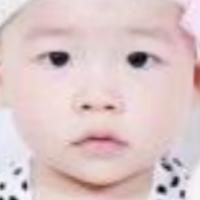

In [37]:
df.iloc[1]['img']

In [ ]:
@delegates(plt.Axes.imshow, keep=True, but=['shape', 'imlim'])
def show_image(im, ax=None, figsize=None, title=None, ctx=None, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    # Handle pytorch axis order
    if hasattrs(im, ('data','cpu','permute')):
        im = im.data.cpu()
        if im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=array(im)
    # Handle 1-channel images
    if im.shape[-1]==1: im=im[...,0]

    ax = ifnone(ax,ctx)
    if figsize is None: figsize = (_fig_bounds(im.shape[0]), _fig_bounds(im.shape[1]))
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.axis('off')
    return ax